In [152]:
import numpy as np
import pyoscode
import matplotlib.pyplot as plt
plt.ion()
import scipy.special as sp
import scipy.integrate
from scipy.optimize import minimize_scalar
from IPython.display import IFrame

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, FloatSlider,FloatLogSlider, SelectMultiple
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline


from IPython.core.display import HTML
HTML("""
<style>
.slides {
  width: 100% !important;
}
.middle > * {
  vertical-align: middle;
}


</style>
""")


In [153]:
def wkb_step_airy(t,x,dx,h,order,n):
    
    times = np.linspace(t,t+h,n)
    ds0 = 1j*(np.sqrt(t))
    ds1 = -1./4*(t**(-1))
    ds2 = 1j*5./32*(t**(-5./2))
    ds3 = 15./64*(t**(-4.))
    s0 = 1j*2./3*((times)**(3./2)-t**(3./2))
    s1 = -1./4*np.log((times)/t)
    s2 = -1j*5./48*((times)**(-3./2)-t**(-3./2))
    s3 = -5./64*((times)**(-3)-t**(-3))
    
    alls = [s0,s1,s2,s3]
    allds = [ds0,ds1,ds2,ds3]
    fp = np.exp(sum(alls[:order+1]))
    fm = np.conj(fp)
    dfp = sum(allds[:order+1])
    dfm = np.conj(dfp)
    
    Ap = (dx - x*dfm)/(dfp - dfm)
    Am = (dx - x*dfp)/(dfm - dfp)
    
    y = Ap*fp + Am*fm
    return times,y
    

# pyoscode: fast solutions of oscillatory ODEs in physics



### Fruzsina Agocs

<img src="images/cambridge.png" width=400 align="left" style="margin: 10px 0px 30px 0px "><img src="images/caplogo.svg" width=120 align="left" style="margin: 10px 0px 30px 30px "><img src="images/kavli.jpg" width=110 align="left" style="margin: 0px 0px 0px 30px ">

<br />
<br />
<br />
<br />
<br />

To run these slides in jupyter,\
head to https://github.com/fruzsinaagocs/oscode and
<a href="https://mybinder.org/v2/gh/fruzsinaagocs/oscode/dense-output-devel?filepath=pyoscode_scipy.ipynb">
<img src="https://mybinder.org/badge_logo.svg" align="right" width=200 style="margin: 8px 620px 0px 0px"></a>


## Introduction

- pyoscode is a numerical solver for **osc**illatory **o**rdinary **d**ifferential **e**quations
- ODEs can be oscillatory through
    - an oscillatory forcing term,  $$\ddot{x} + x = C\cos{\omega t},\; \omega \gg 1$$
    - oscillatory coefficients, $$\dot{x} = xt + 10x\cos{\omega t},\; \omega \gg 1$$
    - slowly changing, but high frequency, $$\ddot{x} + 2\gamma(t)\dot{x} + \omega^2(t) x = 0,\; \omega \gg 1$$
- oscode deals with the third type:
    - one-dimensional
    - ordinary
    - $\omega(t)$, $\gamma(t)$ vary slowly for _at least part of the integration range_

### Motivation

- all extremely common in physics: pendula, suspension, circuits, celestial mechanics, ...
- even if $\omega(t)$ changes slowly, if $\omega \gg 1$, numerical solution slow
- e.g. $\ddot{x} + tx = 0$, the Airy equation:

In [154]:
def f(t,x):
    return np.array([x[1],-t*x[0]])

ti = 1.0
tf = 1e3
x0 = np.array([sp.airy(-ti)[0], -sp.airy(-ti)[1]])

In [155]:
%%time
sol = scipy.integrate.solve_ivp(f,(ti,tf),x0,rtol=1e-3)
print(sol.success)
print("x(t={})={:.4f}, dx/dt={:.4f}".format(tf,sol.y[0][-1],sol.y[1][-1]))
print("analytic solution: x={:.4f}, dx/dt={:.4f}".format(sp.airy(-tf)[0],-sp.airy(-tf)[1]))

True
x(t=1000.0)=0.0302, dx/dt=-2.3852
analytic solution: x=0.0560, dx/dt=-2.6331
CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.8 s


- why the noticeable wall time?
    - `scipy.integrate.solve_ivp`'s default method is 4(5) order Runge-Kutta
    - Runge-Kutta excellent for non-stiff, non-oscillatory equations/regions
    - cannot deal with high-frequency oscillations (will see why)
    - the Airy frequency $\omega(t) = \sqrt{t}$, steadily increases with time

## A brief summary of the algorithm

Based on <cite data-cite="3574492/7LA4L3AM"></cite> [arxiv:1906.01421](https://arxiv.org/abs/1906.01421)

### Runge-Kutta (RK) steps 

- $ \dot{\vec{x}} = F(\vec{x}) $
- have (estimate of) solution $x$ at $t_i$, want to get $x$ at $t_i+h$
- Taylor expand: 

$$x(t_i+h) = x(t_i) + hF(x(t_i)) + \frac{1}{2}h^2\left.\frac{dF}{dt}\right\vert_{t=t_i} + \mathcal{O}(h^3)$$

- and replace derivatives of $F$ with evaluations of $F$ at gridpoints:

$$ x(t_i+h) = x(t_i) + \sum_{j,\;t_i<t_j<t_i+h} hb_jF(x(t_j)) $$

- error goes as $h^n$ $\to$ $h$ breaks down at large $h$
- approximate solution as a _polynomial_ $\to$ if $x$ oscillates, breaks down after $\approx 1$ wavelength
- small steps $\to$ more computing time
- need alternative for when solution is highly oscillatory

### Wentzel-Kramers-Brillouin (WKB) approximation

$$\ddot{x} + \omega^2(t)x = 0$$
- WKB is an _asymptotic_ expansion of the solution: $x(t) \sim Ae^{S_0(t) + S_1(t) + S_2(t) + \ldots}$ 
- $S_0 = \pm i\int{\omega dt}$ $\to$ $x(t) \sim Ae^{i\phi(t)}$ 
- $S_1 = -\frac{1}{2}\ln{\omega}$, $\to$ $x(t) \sim A(t) e^{i\phi(t)}$ 
- approximation good when $\omega$ is "slowly changing", $\left|\frac{\dot{\omega}}{\omega}\right| \ll 1$
- asymptoticity: successive terms decrease up until critical term, then increase

In [156]:
def airy_order(t0, order):
    
    t1 = t0 + 30.0
    x0 = sp.airy(-t0)[0]
    dx0 = -sp.airy(-t0)[1]
    times, sol = wkb_step_airy(t0,x0,dx0,t1-t0,order,1000)
    times_dense = np.linspace(t0,t1,1000)
    sol_dense = np.array([sp.airy(-t)[0] for t in times_dense])
    fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=True)
    plt.tight_layout()
    plt.title('WKB approximation for the Airy equation, $\ddot{x} + tx = 0$')
    ax[0].plot(times_dense,sol_dense,color='black',label='analytic solution')
    ax[0].plot(times,sol,color='C1',label='WKB, order: {}'.format(order)) 
    ax[0].set_ylim(-0.6,0.6)
    ax[0].set_ylabel('$x$')
    ax[0].legend()
    ax[1].semilogy(times_dense,abs(sol-sol_dense),color='black')    
    ax[1].set_ylim((1e-7,1e-0))
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('$|\Delta x|$')
    plt.show()

interact(airy_order, 
         t0=FloatSlider(min=1.0, max=10.0, step=1.0), order=IntSlider(min=0, max=3,
                           step=1), continuous_update=False);

interactive(children=(FloatSlider(value=1.0, description='t0', max=10.0, min=1.0, step=1.0), IntSlider(value=0…

### WKB steps

- embed WKB approximation in a "stepper"
- let $f_{\pm}(t)$ be the two independent WKB solutions: 
$$ f_{+}(t) = e^{S_0+S_1+S_2+\ldots}, \; f_{-}(t) = e^{-S_0+S_1-S_2+\ldots}  $$
- then linearly combine at each step: 
$$ x(t+h) = A_{+}(t)f_{+}(t+h) + A_{-}(t)f_{-}(t+h) $$
$$ \dot{x}(t+h) = B_{+}(t)\dot{f}_{+}(t+h) + B_{-}(t)\dot{f}_{-}(t+h) $$
- this _resets_ the WKB approximation, and reduces to Euler's method in the limit $h\to 0$:
$$ x(t+h) = x(t) + h\dot{x}(t) $$
$$ \dot{x}(t+h) = \dot{x}(t) + h\ddot{x}(t) $$

### Speaker notes:

- WKB inherently one-dimensional
- notice the $\pm$ sign in WKB terms $\to$ two solutions possible
- alternate terms purely real or imaginary -> only affecting amplitude/phase

### &ldquo;RKWKB&rdquo; method

- step along the numerical solution (initial value problem solver)
- 2 components:
    - _adaptive stepsize_ : change stepsize ($h$) based on estimate of local error
    - _switching_ : between RK and WKB steps
        - whichever gives larger $h$ to keep local error within user-specified tolerance
        - use common set of function evaluations $\to$ minimum evaluations per step
- local error estimated as difference between $n^{\mathrm{th}}$ and $(n-1)^{\mathrm{th}}$ method
- details in <cite data-cite="3574492/7LA4L3AM"></cite> [arxiv:1906.01421](https://arxiv.org/abs/1906.01421)

In [157]:
n = 40.
ts1 = np.linspace(-n/2,n/2,100000)
ws1 = np.log(np.sqrt((n**2-1.)))-np.log(1+ts1**2)
gs1 = np.zeros_like(ts1)
ti1 = ts1[0]
tf_dense = ts1[-1]
xi1 = np.sqrt(1.+ti1**2)/n*np.cos(n*np.arctan(ti1))
dxi1 = 1./(n*np.sqrt(1+ti1**2))*(ti1*np.cos(n*np.arctan(ti1))-n*np.sin(n*np.arctan(ti1)))
xs_ana = np.sqrt(1.+ts1**2)/n*(np.cos(n*np.arctan(ts1))) 
solution1 = pyoscode.solve(ts1,ws1,gs1,ti1,tf_dense,xi1,dxi1,logw=True,rtol=1e-3)

def burst_f(t,y):
    return np.array([y[1],-(n**2-1.)/(1.+t**2)**2*y[0]])

def burst_rk(tf):
    
    sol = scipy.integrate.solve_ivp(burst_f,(ti1,tf),np.array([xi1,dxi1]),rtol=1e-3)
    t_rk = sol.t
    final_ind = np.argmax(t_rk >= tf)
    
    t_rk = t_rk[:final_ind+1]
    x_rk = sol.y[0][:final_ind+1]
    
    plt.figure(figsize=(10,2.5))
    plt.tight_layout()
    plt.title("scipy.integrate.solve_ivp solving the equation $\ddot{x}+\\frac{n^2-1}{(1+t^2)^2}x=0$, with $n=40$")
    plt.plot(ts1,xs_ana,label='analytic solution',color='black',lw=0.7)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.plot(t_rk,x_rk ,'.',label='RK',ms=9.0,color='C1')
    plt.legend()    

def burst(tf):
     
    t_osc = np.array(solution1['t'])
    final_ind = np.argmax(t_osc >= tf)
            
    t_osc = t_osc[:final_ind+1]
    x_osc = np.array(solution1['sol'])[:final_ind+1]
    types = np.array(solution1['types'])[:final_ind+1]
    t_rk = t_osc[types==0]
    x_rk = x_osc[types==0]
    t_wkb = t_osc[types==1]
    x_wkb = x_osc[types==1]
    plt.figure(figsize=(10,2.5))
    plt.tight_layout()
    plt.title("oscode solving the equation $\ddot{x}+\\frac{n^2-1}{(1+t^2)^2}x=0$, with $n=40$")
    plt.plot(ts1,xs_ana,label='analytic solution',color='black',lw=0.7)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.plot(t_rk,x_rk ,'.',label='RK',ms=9.0,color='C1')
    plt.plot(t_wkb,x_wkb,'.',label='WKB',ms=9.0,color='C0')
    plt.legend()
    

interact(burst, 
         tf=FloatSlider(min=ti1, max=tf_dense,
                           step=1.0, continuous_update=False, value=ti1));

interact(burst_rk, 
         tf=FloatSlider(min=ti1, max=tf_dense,
                           step=1.0, continuous_update=False, value=ti1));

interactive(children=(FloatSlider(value=-20.0, continuous_update=False, description='tf', max=20.0, min=-20.0,…

interactive(children=(FloatSlider(value=-20.0, continuous_update=False, description='tf', max=20.0, min=-20.0,…

In [158]:
def burst2(n2):
    
    ts2 = np.linspace(-n2,n2,500000)
    ws2 = np.log(np.sqrt((n2**2-1.)))-np.log(1+ts2**2)
    gs2 = np.zeros_like(ts2)
    ti2 = ts2[0]
    tf_dense = ts2[-1]
    xi2 = np.sqrt(1.+ti2**2)/n2*np.cos(n2*np.arctan(ti2))
    dxi2 = 1./(n2*np.sqrt(1+ti2**2))*(ti2*np.cos(n2*np.arctan(ti2))-n2*np.sin(n2*np.arctan(ti2)))
    xs_ana2 = np.sqrt(1.+ts2**2)/n2*(np.cos(n2*np.arctan(ts2))) 
    solution2 = pyoscode.solve(ts2,ws2,gs2,ti2,tf_dense,xi2,dxi2,logw=True,rtol=1e-3)
     
    t_osc = np.array(solution2['t'])

    oscs = np.zeros(len(t_osc))
    for i,t in enumerate(t_osc):
        if i!=0:
            oscs[i] = ((n2*np.arctan(t)/(2*np.pi))-(n2*np.arctan(t_osc[i-1])/(2*np.pi)))
        else:
            oscs[i] = None
    
    types = np.array(solution2['types'])
    t_rk = t_osc[types==0]
    t_wkb = t_osc[types==1]
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    plt.title("Number of oscillations traversed per step, $\ddot{{x}}+\\frac{{n^2-1}}{{(1+t^2)^2}}x=0$, n={}".format(n2))
    plt.xlabel('t')
    plt.ylabel('$N_{\mathrm{osc}}$')
    plt.semilogy(t_osc,oscs,color='black')
    plt.semilogy(t_rk,oscs[types==0] ,'.',label='RK',ms=9.0,color='C1')
    plt.semilogy(t_wkb,oscs[types==1],'.',label='WKB',ms=9.0,color='C0')
    plt.ylim((1e-2,1e4))
    plt.legend()
    

interact(burst2, 
         n2=FloatLogSlider(base=10, min=2, max=5,
                           step=1), continuous_update=False);

interactive(children=(FloatLogSlider(value=100.0, description='n2', max=5.0, min=2.0, step=1.0), Output()), _d…

- Airy equation revisited with pyoscode (~2 s runtime with `scipy`):

In [181]:
ts = np.linspace(0,1e3,5000)
ws = np.sqrt(ts)
gs = np.zeros_like(ts)

# Initial conditions
ti = 1.0
tf = ts[-1]
x0 = sp.airy(-ti)[0]
dx0 = -sp.airy(-ti)[1]

In [182]:
%%time
pyoscode_sol = pyoscode.solve(ts,ws,gs,ti,tf,x0,dx0,rtol=1e-3)
pyosc_y = pyoscode_sol['sol']
pyosc_dy = pyoscode_sol['dsol']
print("x(t={})={:.4f}, dx/dt={:.4f}".format(tf,pyosc_y[-1],pyosc_dy[-1]))
print("analytic solution: x={:.4f}, dx/dt={:.4f}".format(sp.airy(-tf)[0],-sp.airy(-tf)[1]))

x(t=1000.0)=0.0560+0.0000j, dx/dt=-2.6292+0.0000j
analytic solution: x=0.0560, dx/dt=-2.6331
CPU times: user 563 µs, sys: 12 µs, total: 575 µs
Wall time: 460 µs


## Examples in physics

### Cosmology

- origins of large-scale structure thought to have been quantum fluctuations 
- fluctuations grew during a period of accelerated expansion, inflation ($t < \;\sim 10^{-32}$ s)
- power spectrum of _gauge-invariant curvature perturbations_ $\to$ cosmic microwave background (CMB)
- to infer physics of early universe, need to assume or compute (primordial) power spectrum

<img src="images/cmb.png" width=700 text-align="center" style="margin: 50px 450px">



#### Computing a primordial power spectrum

- homogeneous, isotropic background + small perturbations
- primordial power spectrum: |perturbations|${}^2$ as function of Fourier wavenumber
- background: single-field quadratic inflation, spatially flat universe
$$ \dot{H} + H^2 = -\frac{1}{3m_P^2}\left(\dot{\phi}^2 - V(\phi)\right) $$
$$ H^2 = \frac{1}{3m_P^2}\left(\tfrac{1}{2}\phi^2 +V(\phi) \right)$$
$$ 0 = \ddot{\phi} + 3H\dot{\phi} + V'(\phi) $$

    - $a$: scale factor, $H$: Hubble parameter, $\phi$: inflaton field, $m_P$: Planck mass
    - $V(\phi) \propto \phi^2$ inflaton potential


In [161]:
def V(phi):
    """ inflationary potential"""
    return 0.5*m**2*phi**nv

def dV(phi):
    """ derivative of the inflationary potential """
    return 0.5*nv*m**2*phi**(nv-1)

def bgeqs_t(t, y):
    """ System of equations describing the evolution of the cosmological
    background in terms of cosmic time t """
    # y: a,H,phi,dphi/dt
    dy = np.zeros(y.shape)
    dy[0] = y[0]*y[1]
    dy[1] = -1./3*(y[3]**2 - V(y[2])) - y[1]**2
    dy[2] = y[3]
    dy[3] = -3*y[1]*y[3] - dV(y[2])
    return dy

def endinfl_t(t, y):
    """ Crosses zero when inflation ends """
    return -1./3*(y[3]**2-V(y[2]))*y[0]

m = 1e-4
mp = 1
nv = 2 
K = 0

# Solve background in terms of t
t_ini = 1.
t_fin = 1e6
a_ini = t_ini**(1./3)
H_ini = 1./(3*t_ini)
phi_ini = 23.0
dphi_ini = - np.sqrt(2./3)/t_ini
y_ini =[a_ini, H_ini, phi_ini, dphi_ini]
#endinfl_t.terminal=True
#endinfl_t.direction=-1
bgsol_t = scipy.integrate.solve_ivp(bgeqs_t, (t_ini,t_fin), y_ini, events=endinfl_t, rtol=1e-4)
bg_ts = bgsol_t.t
phis_t = bgsol_t.y[2]
as_t = bgsol_t.y[0]
Hs_t = bgsol_t.y[1]

def plot_bg(keywords):

    qties = {'scale factor':("$a$",as_t), 'Hubble parameter':("$H$",Hs_t), \
             'Hubble horizon':("$\\frac{1}{aH}$",1./(as_t*Hs_t)), 'inflaton field':("$\phi$",phis_t)}
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    plt.title("Evolution of background quantities with cosmic time")
    for keyword in keywords:
        if keyword not in ['inflaton field']:
            plt.loglog(bg_ts,qties[keyword][1],label='{}'.format(keyword))
        else:            
            plt.semilogx(bg_ts,qties[keyword][1],label='{}'.format(keyword))
        plt.ylabel("{}".format(qties[keyword][0]))
    plt.xlabel("cosmic time $t$")
    plt.legend()
    
interact(plot_bg, keywords=SelectMultiple(
    options=['scale factor', 'Hubble parameter', 'Hubble horizon', 'inflaton field'],
    value=['scale factor'],
    description='Plot: ',
    disabled=False),
    style=dict(description_width='initial'));

interactive(children=(SelectMultiple(description='Plot: ', index=(0,), options=('scale factor', 'Hubble parame…

- perturbations: 
    - equation of motion is the Mukhanov-Sasaki equation:
    $$ \ddot{\mathcal{R}}_k + 2\left( \frac{\ddot{\phi}}{\phi} -\frac{1}{2} \dot{\phi}^2 + \frac{3}{2}\right)\dot{\mathcal{R}}_k + \left( \frac{k}{aH} \right)^2\mathcal{R}_k = 0 $$
        - $\mathcal{R}_k$ is gauge-invariant curvature perturbation with Fourier wavenumber $k$
        - characteristic lengthscale of perturbation $= k^{-1}$
        - using $N = \ln{a}$ as independent variable
        - oscillator with time-dependent frequency and damping
        - frequency $\propto k \to$ can get large, computationally challenging
        - $\omega$, $\gamma$ not closed-form functions
    

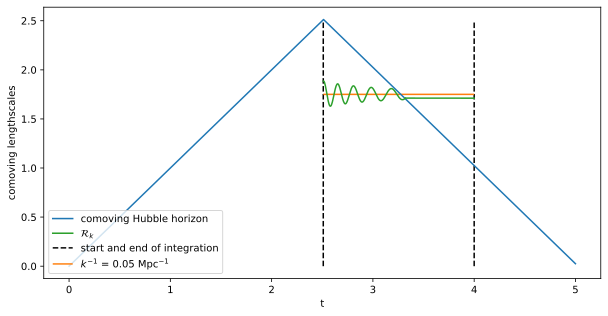

In [162]:
t_schem = np.linspace(0,5,200)
hor_schem = np.concatenate((t_schem[:100],t_schem[100]-t_schem[:100]))
t_wig = np.linspace(2.51,3.32,200)
x_wig = 1.75+0.07*np.cos(300/t_wig)/(t_wig-2)
t_eva = np.linspace(3.32,4.0,200)
x_eva = x_wig[-1] + 0.001*np.exp(-(t_eva-t_wig[-1]))
plt.figure(figsize=(10,5))
plt.tight_layout()
plt.xlabel("t")
plt.ylabel("comoving lengthscales")
plt.plot(t_schem, hor_schem,label='comoving Hubble horizon')
plt.vlines([2.51,4.0],0.0,2.5,linestyles='dashed',label='start and end of integration')
plt.hlines(1.75,2.51,4.0,label='$k^{-1}$ = 0.05 Mpc${}^{-1}$',color='C1')
plt.plot(t_wig,x_wig,color='C2')
plt.plot(t_eva,x_eva,color='C2',label='$\mathcal{R}_k$')
plt.legend(loc='lower left')
plt.show()

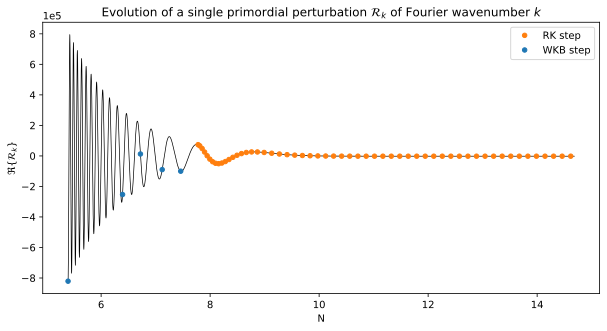

In [163]:
import re

pair = re.compile(r'\(([^,\)]+),([^,\)]+)\)')
def parse_pair(s):
    s = s.decode('utf-8')
    return complex(*map(float, pair.match(s).groups()))

f1 = "images/bingo-singlek-k1e-5.txt"
f1ref = "images/bingo-singlek-k1e-5-ref.txt"
f1wkb = "images/rkwkb-single-k1e-5.txt"
d1 = np.genfromtxt(f1)
d1ref = np.genfromtxt(f1ref)
d1wkb = np.genfromtxt(f1wkb,dtype=complex,converters={1:parse_pair, 2:parse_pair})
n1 = d1[:,0]
n1ref = d1ref[:,0]
n1wkb = d1wkb[:,0]
rk1 = d1[:,1]
rk1ref = d1ref[:,1]
rk1wkb = d1wkb[:,1]
rk1steps = d1wkb[:,3]

f2 = "images/bingo-singlek-k1e8.txt"
f2ref = "images/bingo-singlek-k1e8-ref.txt"
f2wkb = "images/rkwkb-single-k1e8.txt"
d2 = np.genfromtxt(f2)
d2ref = np.genfromtxt(f2ref)
d2wkb = np.genfromtxt(f2wkb,dtype=complex,converters={1:parse_pair, 2:parse_pair})
n2 = d2[:,0]
rk2 = d2[:,1]
rk2 = rk2*rk1[0]/rk2[0]
n2 = n2 - (n2[0] - n1[0])
n2ref = d2ref[:,0]
rk2ref = d2ref[:,1]
rk2ref = rk2ref*rk1ref[0]/rk2ref[0]
n2ref = n2ref - (n2ref[0] - n1ref[0])
n2wkb = d2wkb[:,0]
rk2wkb = d2wkb[:,1].real
rk2wkb = rk2wkb*rk1wkb[0].real/rk2wkb[0].real
n2wkb = n2wkb - (n2wkb[0] - n1wkb[0])

plt.figure(figsize=(10,5))
plt.title('Evolution of a single primordial perturbation $\mathcal{R}_k$ of Fourier wavenumber $k$')
plt.plot(n1ref,rk1ref,color='black',lw=0.7)
plt.plot(n1wkb[rk1steps==0],rk1wkb[rk1steps==0],'.',color='C1',ms=9.0,label='RK step')
plt.plot(n1wkb[rk1steps==1],rk1wkb[rk1steps==1],'.',color='C0',ms=9.0,label='WKB step')
plt.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
plt.legend()
plt.xlabel('N')
plt.ylabel('$\Re{\{ \mathcal{R}_k \}} $')
plt.show()


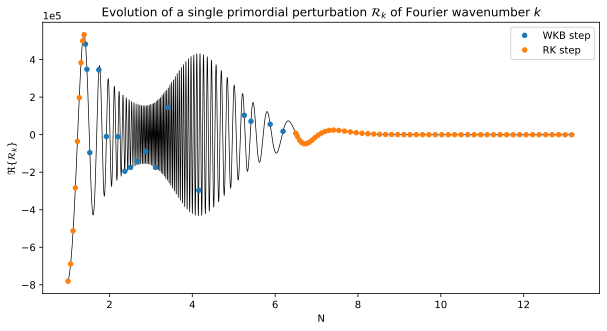

In [164]:
fs1 = "images/singlek-kd-bd-2a.txt"
fs2 = "images/singlek-kd-bd-2a.txt"
fref = "images/singlek-kd-bg-2a-ref.txt"
d1 = np.genfromtxt(fs1,dtype=complex,converters={1:parse_pair,2:parse_pair,4:parse_pair})
d2 = np.genfromtxt(fs2,dtype=complex,converters={1:parse_pair,2:parse_pair,4:parse_pair})
dref = np.genfromtxt(fref)
n1 = d1[:,0]
n2 = d2[:,0]
nref = dref[:,0]
rk1 = d1[:,1]
rk2 = d2[:,1]
rkref = dref[:,1]
wkb1 = d1[:,3]
wkb2 = d2[:,3]
plt.figure(figsize=(10,5))
plt.title('Evolution of a single primordial perturbation $\mathcal{R}_k$ of Fourier wavenumber $k$')
plt.plot(nref,rkref,color='black',lw=0.7)
plt.plot(n1[wkb1==1],(rk1[wkb1==1]),'.',color='C0',label='WKB step',ms=9.)
plt.plot(n1[wkb1==0],(rk1[wkb1==0]),'.',color='C1',label='RK step',ms=9.)
plt.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
plt.xlabel('N')
plt.ylabel('$\Re{\{ \mathcal{R}_k \}} $')
plt.legend()
plt.show()
 

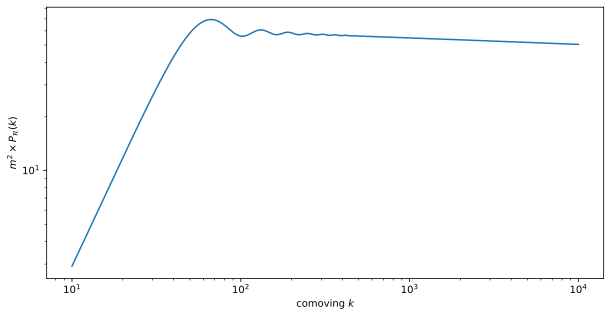

In [165]:
def bgeqs(t, y):
    """ System of equations describing the evolution of the cosmological
    background in terms of e-folds, N """
    dy = np.zeros(y.shape)
    dy[0] = 4.0 + np.exp(y[0])*(4.0*K - 2.0*np.exp(2.0*t)*V(y[1]))
    dy[1] = - np.sqrt(6.0 + np.exp(y[0])*(6.0*K -
    2.0*np.exp(2.0*t)*V(y[1])))
    return dy

def endinfl(t, y):
    """ Crosses zero when inflation ends """
    dphi = bgeqs(t,y)[1]
    epsilon = 0.5*dphi**2
    return epsilon - 1.

def bdic(k, phi, dphi, ddphi, N):
    """ Defines the Bunch-Davies vacuum solution
    for a given perturbation mode """
    a0 = np.exp(N)
    dz_z = ddphi/dphi + 1.
    z = a0*dphi
    R = 1./(np.sqrt(2.*k)*z) + 1j*0
    dR = - R*dz_z - np.sqrt(k/2.*ok_i)/z*1j
    return R,dR

def pps(k, rk1, rk2, x01, dx01, x02, dx02, x0, dx0):
    """ Enforces x,dx as initial conditions by linear
    combination of two solutions rk1 and rk2, which had
    initial conditions x01, dx01 and x02, dx02 """
    a = (x0*dx02 - dx0*x02)/(x01*dx02 - dx01*x02)
    b = (x0*dx01 - dx0*x01)/(x02*dx01 - dx02*x01)
    power = np.abs(a*rk1 + b*rk2)**2*k**3/(2*np.pi**2)
    return power

# Solve in terms of N
# \Omega_k and N at the start of inflation fully
# parametrise the background.
m = 1
ok_i = 2.1e-3
N_i = 1.
# Nominal end point of integration (we'll stop at the end of inflation)
N_f = 80.
# Points at which we'll obtain the background solution
Nbg = 50000 # This determines grid fineness, see note below.
N = np.linspace(N_i,N_f,Nbg)
# Initial conditions
phi_i = np.sqrt(4.*(1./ok_i + K)*np.exp(-2.0*N_i)/m**2)
logok_i = np.log(ok_i)
y_i = np.array([logok_i, phi_i])
# Solve for the background until the end of inflation
endinfl.terminal = True
endinfl.direction = 1
bgsol = scipy.integrate.solve_ivp(bgeqs, (N_i,N_f), y_i, events=endinfl, t_eval=N, rtol=1e-8, atol=1e-10)

Ns = bgsol.t
logoks = bgsol.y[0]
phis = bgsol.y[1]

logok = bgsol.y[0]
phi = bgsol.y[1]
N = bgsol.t
dphi = np.array([-np.sqrt(6.0 + np.exp(Logok)*(6.0*K -
    2.0*np.exp(2.0*t)*V(Phi))) for Logok,Phi,t in zip(logok,phi,N) ])
dlogok = np.array([4.0 + np.exp(Logok)*(4.0*K - 2.0*np.exp(2.0*t)*V(Phi)) for Logok,Phi,t in zip(logok,phi,N) ])
dE_E = dlogok - 4. -2.*dV(phi)*np.exp(logok)*np.exp(2.*N)/dphi
E = 0.5*dphi**2
# Damping term
g = 0.5*(3 - E + dE_E)
# frequency
logw = 0.5*logok

# range of wavevectors
ks = np.logspace(1,4,800)
end = np.zeros_like(ks,dtype=int)
endindex = 0
for i in range(len(ks)):
    for j in range(endindex,Nbg):
        if np.exp(-0.5*logok[j])/ks[i] > 100:
            end[i] = j
            endindex = j
            break

spectrum = np.zeros_like(ks,dtype=complex)
for i,k in enumerate(ks):
    # Bunch-Davies i.c.
    phi_0 = phi[0]
    dphi_0 = dphi[0]
    ddphi_0 = 0.5*dE_E[0]*dphi_0
    N_0 = N_i
    x0, dx0 = bdic(k, phi_0, dphi_0, ddphi_0, N_0)
    x01 = 1.0
    dx01 = 0.0
    x02 = 0.0
    dx02 = 1.0
    # Linearly indep. solutions
    sol1 = pyoscode.solve(N,logw+np.log(k),g,N_i,N[end[i]],x01,dx01,logw=True)
    sol2 = pyoscode.solve(N,logw+np.log(k),g,N_i,N[end[i]],x02,dx02,logw=True)
    rk1 = sol1["sol"][-1]
    rk2 = sol2["sol"][-1]
    spectrum[i] = pps(k, rk1, rk2, x01, dx01, x02, dx02, x0, dx0)

plt.figure(figsize=(10,5))
plt.tight_layout()
plt.loglog(ks, spectrum)
plt.xlabel('comoving $k$')
plt.ylabel('$m^2 \\times P_{\mathcal{R}}(k)$')
plt.show()

- computation of spectrum _can be_ bottleneck in forward modelling, e.g.
    - closed universes <cite data-cite="3574492/2VK67JYP"></cite> [arxiv:1907.08524](https://arxiv.org/abs/1907.08524)
    - axion monodromy models <cite data-cite="3574492/MC4FCNHB"></cite> [arxiv:1502.02114](https://arxiv.org/abs/1502.02114)
    - initial conditions set at very early times <cite data-cite="3574492/ZT4XDK5S"></cite> [arXiv:2002.07042](https://arxiv.org/abs/2002.07042)

<img src=" https://github.com/fruzsinaagocs/oscode/raw/master/pyoscode/images/spectra.gif" width=700 text-align="center" style="margin: 0px 450px">




### Quantum mechanics

- time-independent, one-dimensional Schrödinger equation: 

$$ \Psi''(x) + 2m(E-V(x))\Psi(x) = 0 $$

- $\Psi$ is wavefunction, $V(x)$ potential well, $E$ are _unknown_ energy eigenvalues of the system to be determined
- a harmonic oscillator with time-dependent frequency that can be real or imaginary
- a _boundary value problem_ :
    - continuity of $\Psi$ and $\Psi'$ required at edges of potential well where $E = V(x)$
    - $\Psi(x)\to 0$ far outside the well where $V(x) \gg E$ 

- can rephrase as optimisation problem:
    - guess lower and upper bound for $n^{\mathrm{th}}$ eigenvalue $E_n$
    - start from initial guess for $E_n$ within bounds
    - propagate two solutions from outside the potential well ( _initial value problems_ )
    - check for continuity between two solutions, $\Psi_L$ and $\Psi_R$, at midpoint
    - eigenvalue found when $\left\vert\frac{\Psi_L'}{\Psi_L}-\frac{\Psi_R'}{\Psi_R}\right\vert = 0$

- Try potential of the form $V(x) = x^2 + \lambda x^4$, the anharmonic oscillator
- $\lambda=1$, find $n^{\mathrm{th}}$ energy levels with $n=\{$50, 100, 1000, 10000$\}$ 
- Numerical values using a conventional method: $E_n=$ 417.05626, 1035.5442, 21932, 7840, 471103.80 <cite data-cite="3574492/5I6RED6P"></cite>

Eigenenergy found: 417.05617063245677
Eigenenergy found: 1035.5440560800544
Eigenenergy found: 21932.790103840813
Eigenenergy found: 471103.8093756515


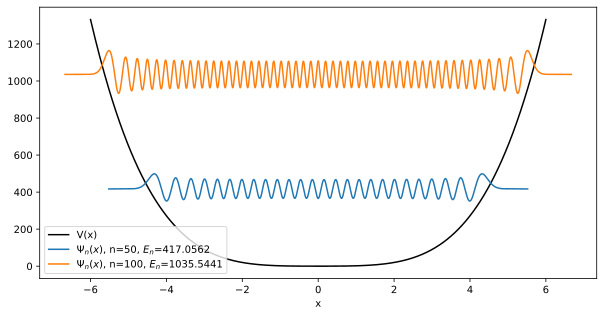

In [180]:
l=1.0
m=0.5

def Ei(n):
    """ 
    Energy eigenvalues (if analytic solution available)
    """
    return np.sqrt(2.0)*(n-0.5)

def V(t):
    """ 
    Potential well 
    """
    return t**2 + l*t**4

def w(t,E):
    """
    Frequency term in the Schrodinger equation
    """
    return np.sqrt(2*m*(complex(E)-V(t)));

def f(E):
    """
    Function to minimize wrt E to give the energy eigenvalues
    """

    # Boundaries of integration
    tl = -((E)**(0.25))-2.0
    tr = -tl
    tm = 0.5

    # Grid of w, g
    t = np.linspace(tl.real,tr.real,30000)
    ws = np.log(w(t,E))
    g = np.zeros(t.shape)
    sol_l = pyoscode.solve(t,ws,g,tl,tm,0,1e-3,logw=True,rtol=1e-5)
    sol_r = pyoscode.solve(t,ws,g,tr,tm,0,1e-3,h=-1,logw=True,rtol=1e-5)
    psi_l = sol_l["sol"][-1]
    psi_r = sol_r["sol"][-1]
    dpsi_l = sol_l["dsol"][-1]
    dpsi_r = sol_r["dsol"][-1]
    try:
        return abs(dpsi_l/psi_l - dpsi_r/psi_r)
    except ZeroDivisionError:
        return 1000.0
    
def plot(ns,Es):

    plt.figure(figsize=(10,5))
    t_v = np.linspace(-6,6,500)
    plt.plot(t_v,V(t_v),color='black',label='V(x)')

    for j,n,E in zip(range(len(ns)),ns,Es):
        # Boundaries of integration
        tl = -((E)**(0.25))-1.0
        tr = -tl
        tm = 0.0

        # Grid of w, g
        t = np.linspace(tl.real,tr.real,30000)
        ws = np.log(w(t,E))
        g = np.zeros(t.shape)

        sol_l = pyoscode.solve(t,ws,g,tl,tr/2.,0,1e-3,logw=True,rtol=1e-5)
        x_l = sol_l['sol']
        ts_l = sol_l['t']
        types_l = sol_l['types']
        for i,typ in enumerate(types_l):
            if typ==1 and 0 not in types_l[i:]:
                firstwkb = i
                break;



        t_eval = np.linspace(ts_l[firstwkb],tm,2000)
        sol = pyoscode.solve(t,ws,g,tl,tr,0,1e-3,logw=True,rtol=1e-5,t_eval=t_eval)

        x_eval = sol['x_eval']
        x_l = x_l[:firstwkb]
        ts_l = ts_l[:firstwkb]
        Ts_l = np.concatenate((np.array(ts_l),t_eval))
        Xs_l = np.concatenate((np.array(x_l),x_eval))
        maxx = max(np.real(Xs_l))
        Xs_l = Xs_l/maxx*4*np.sqrt(E)
        plt.plot(Ts_l,Xs_l+E,color='C{}'.format(j),label='$\Psi_n(x)$, n={}, $E_n$={:.4f}'.format(n,E))
        plt.plot(-1*Ts_l,Xs_l+E,color='C{}'.format(j))
    plt.xlabel('x')
    plt.legend(loc='lower left')
    plt.show()

bounds = [ (416.5,417.5),(1035,1037),(21930,21940),(471100,471110)]

ress = []
for bound in bounds:
    res = minimize_scalar(f,bounds=bound,method='bounded')
    print("Eigenenergy found: {}".format(res.x))
    ress.append(res.x)
plot([50,100],ress[:2])


### Other examples

- modelling the mechanics of the cochlea <cite data-cite="3574492/5BZSXUB8"></cite> [doi:10.1155/2014/150637](https://doi.org/10.1155/2014/150637)
    - cochlea map sounds of different frequencies onto unique positions on the basilar membrane
- normal modes in black holes <cite data-cite="3574492/LYQIAQKR"></cite> [doi:10.1103/PhysRevD.35.3632](https://doi.org/10.1103/PhysRevD.35.3632)
    - resonant, nonradial perturbations of black holes caused by external perturbations
- scattering of radio waves from overdense meteor trains <cite data-cite="3574492/8WK2IYN7"></cite> [doi:10.1016/0032-0633(92)90045-P](https://doi.org/10.1016/0032-0633(92)90045-P)
    - symmetry allows radio waves to be decomposed into partial waves, apply WKB to each

## The interface

- draws from `scipy.integrate.solve_ivp(fun, t_span, y0, ...)`
    - `fun`: defines differential equation
    - `t_span`: integration range
    - `y0`: initial conditions
- minimal setup:

In [167]:
import numpy as np
import scipy.special as sp
import pyoscode

# Set up differential equation: x'' + tx = 0.  
ts = np.linspace(0,40.0,5000)
ws = np.sqrt(ts)
gs = np.zeros_like(ts)

# Initial conditions
ti = 1.0
tf = 40.0
x0 = sp.airy(-ti)[0]
dx0 = -sp.airy(-ti)[1]

solution = pyoscode.solve(ts, ws, gs, ti, tf, x0, dx0)
solution.keys()  

dict_keys(['sol', 'dsol', 't', 'types', 'x_eval'])

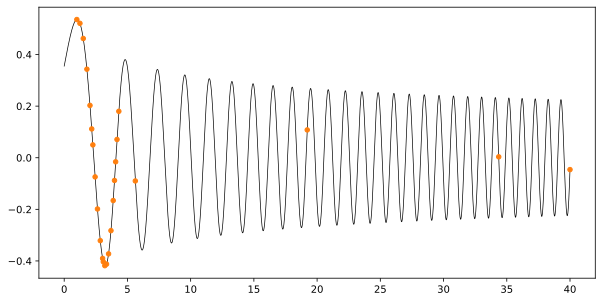

In [168]:
# Compute analytic solution for comparison
analytic = np.array([sp.airy(-t)[0] for t in ts])

plt.figure(figsize=(10,5))
plt.plot(ts,analytic,label='analytic solution',color='black',lw=0.7)
plt.plot(solution['t'],solution['sol'],'.',color='C1',label='pyoscode',ms=9.0)
plt.show()

- optional arguments allow _dense output_ 
    - output solution at user-specified points
    - no extra steps or evaluations of the RHS of the ODE $\to$ computationally cheap 
    - not trivial for highly oscillatory solutions <cite data-cite="3574492/BS7RFP2G"></cite> [arxiv:2007.05013](https://arxiv.org/abs/2007.05013)

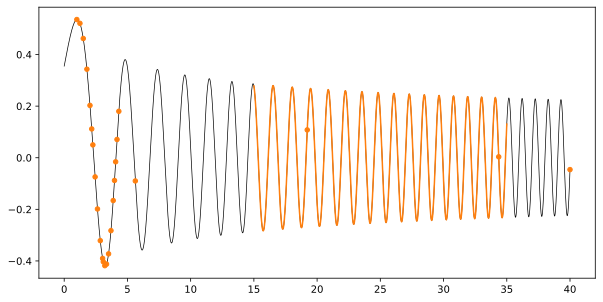

In [173]:
# We'll get the solution at these points@
t_eval = np.linspace(15,35,600)
dense_solution = pyoscode.solve(ts, ws, gs, ti, tf, x0, dx0, t_eval=t_eval)

plt.figure(figsize=(10,5))
plt.plot(ts,analytic,label='analytic solution',color='black',lw=0.7)
plt.plot(dense_solution['t'],dense_solution['sol'],'.',color='C1',label='pyoscode natural step',ms=9.0)
plt.plot(t_eval, dense_solution['x_eval'], color='C1', label='pyoscode dense output')
plt.show()

### Documentation

- https://github.com/fruzsinaagocs/oscode
- open source software, to be submitted to JOSS
- python & C++ documentation at https://oscode.readthedocs.io
- examples available for both interfaces

### Extending pyoscode

- multiple dimensions
    - modified Magnus expansion instead of (inherently 1D) WKB by <cite data-cite="3574492/9XNWYLFA"></cite> [arxiv:1907.11638](https://arxiv.org/abs/1907.11638)
    - more work under way <cite>(Schöneberg and Agocs, &ldquo;Beyond the traditional WKB approximation of Boltzmann equations&rdquo; in prep.)</cite>
- adapt basis function $f_{\pm}$ to problem in question:
    - WKB is suitable for highly oscillatory solutions with slowly changing frequencies
    - different basis may be suitable for e.g. a problem exhibiting sawtooth-shaped oscillations
- adjust order of WKB expansion on the fly
- users, testers, developers welcome

## Thank you, questions welcome!

### References
<div class="cite2c-biblio"></div>

- Quickly cycle through references
- Thank you for your attention
- looking forward to the questions in the live Q&A session

### Speaker notes:

- [cochlear modelling](https://www.researchgate.net/profile/Guangjian_Ni/publication/264903003_Modelling_Cochlear_Mechanics/links/540744090cf23d9765a842bf/Modelling-Cochlear-Mechanics.pdf?_sg%5B0%5D=7AbuZ2A2CESIn1KT188f1ITVZeIfImBoIp5R_bpgWgqC4i_GLjD5Nq41KK-MQYxjDHwxSODEHy_awn5EqyYugg.pahQ2GI9a7_jo6jr2sJr25CplmHEGHVjbYPB8dmOEj41ow5XYpgg7zY5ZsDSkcUYT2p07B6cTddycRdxqjacMw&_sg%5B1%5D=0sZMN8po1Z8DqXBKVDNthMOfRmkqg1blUzMy4fCRQgBqWc9ux42dFP9tuhCuw6maLxybBsYZHGrwCasG-aaohrHFYtmN4-7XuORCwdIse806.pahQ2GI9a7_jo6jr2sJr25CplmHEGHVjbYPB8dmOEj41ow5XYpgg7zY5ZsDSkcUYT2p07B6cTddycRdxqjacMw&_iepl=)
- [black holes](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.35.3621)
- [scattering of radio waves from overdense meteor trains](https://reader.elsevier.com/reader/sd/pii/003206339290045P?token=8D06D887C3C120D4F6BD36090116D9EC70BE0F1E1475C8E5231BB6470082EBD2F91F5BD0DB7BFE9CCDCBA263805E2FB5)